In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings

In [2]:
#Raw csv file from Github
news_data = "https://raw.githubusercontent.com/ml-truth-serum/fake_or_real_news/main/simple_model/Resources/Data/cleaned_news_df.csv"

# Read File
news_df = pd.read_csv(news_data, header=0, encoding='utf-8')
# Display sample data
news_df.head(10)

,id,title,text,label
0,8476.0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294.0,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608.0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142.0,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875.0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903.0,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341.0,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95.0,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869.0,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909.0,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


## Step 1 - Clean the data

In [10]:
#check count of all rows
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6315 entries, 0 to 6314
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      6310 non-null   float64
 1   title   6315 non-null   object 
 2   text    6315 non-null   object 
 3   label   6315 non-null   object 
dtypes: float64(1), object(3)
memory usage: 197.5+ KB


In [11]:
#see datatype
news_df.dtypes

id       float64
title     object
text      object
label     object
dtype: object

In [12]:
#drop the id column
revise_news_df = news_df.loc[:,["title", "text", "label"]]
revise_news_df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Step 2 - Get the columns that we need by transforming the columns

In [13]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [14]:
import unidecode
import re, string

filter_df = pd.DataFrame(revise_news_df)

# Define the clean_text function
def clean_text(input_text):
    # 1. Change text to lower case
    final_text = input_text.lower()
    final_text = unidecode.unidecode(final_text)

    # 2. Remove digits
    final_text = re.sub(r'\d+', '', final_text)

    # 3. Remove punctuation, excluding apostrophes
    exclude = set(string.punctuation) - set("'")
    final_text = ''.join(ch for ch in final_text if ch not in exclude)
    #4 return the value
    return final_text

In [15]:
# Apply the clean_text function to the 'title' and 'text' columns
filter_df['title'] = filter_df['title'].apply(clean_text)
filter_df['text'] = filter_df['text'].apply(clean_text)

filter_df.head()

,title,text,label
0,you can smell hillary's fear,daniel greenfield a shillman journalism fellow...,FAKE
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry to go to paris in gesture of sympathy,us secretary of state john f kerry said monday...,REAL
3,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november the lesson ...,FAKE
4,the battle of new york why this primary matters,it's primary day in new york and frontrunners ...,REAL


In [16]:
# Splitting the 'TextColumn' for each row based on whitespace
filter_df['title_array'] = filter_df['title'].apply(lambda x: x.split())
filter_df['text_array'] = filter_df['text'].apply(lambda x: x.split())

# Drop duplicate words for each row
filter_df['title_array'] = filter_df['title_array'].apply(lambda x: np.unique(x))
filter_df['text_array'] = filter_df['text_array'].apply(lambda x: np.unique(x))

# Only grab the label and the new array columns
transform_array_df = filter_df[['label','title_array', 'text_array']]

transform_array_df.head()

,label,title_array,text_array
0,FAKE,"[can, fear, hillary's, smell, you]","[a, abedin, about, abuses, accused, accusing, ..."
1,FAKE,"[a, at, committed, exact, moment, paul, politi...","['s, a, abc, abcpolitics, about, aboutface, ad..."
2,REAL,"[gesture, go, in, kerry, of, paris, sympathy, to]","[a, about, abroad, act, address, affairs, afte..."
3,FAKE,"['we, against, anger, bernie, dnc, erupt, in, ...","[a, about, according, account, activist, adama..."
4,REAL,"[battle, matters, new, of, primary, the, this,...","[a, about, all, also, and, are, aren't, avoidi..."


In [17]:
transform_array_df = transform_array_df.astype(dtype={'label': 'string'})

transform_array_df.dtypes

label          string
title_array    object
text_array     object
dtype: object

In [18]:
#join array together

join_array_df = transform_array_df.loc[:,["label"]]

# Combine the arrays from both columns into a single array
join_array_df['combo_array'] = transform_array_df.apply(lambda row: np.concatenate([row['title_array'], row['text_array']]), axis=1)


join_array_df.head()

,label,combo_array
0,FAKE,"[can, fear, hillary's, smell, you, a, abedin, ..."
1,FAKE,"[a, at, committed, exact, moment, paul, politi..."
2,REAL,"[gesture, go, in, kerry, of, paris, sympathy, ..."
3,FAKE,"['we, against, anger, bernie, dnc, erupt, in, ..."
4,REAL,"[battle, matters, new, of, primary, the, this,..."


### Title and Label Columns ONLY

In [19]:
# Expand only the title array into new columns
title_expand_array_df = transform_array_df.loc[:, ["label"]]

# Create new columns for each element in the arrays
title_array_columns = pd.DataFrame(transform_array_df['title_array'].tolist(), dtype='string')

# Concatenate the new columns with the original DataFrame
title_expand_array_df = pd.concat([title_expand_array_df, title_array_columns], axis=1)

# Fill in NA with "NA"
title_expand_array_df = title_expand_array_df.fillna("NA")

# Display the DataFrame
title_expand_array_df.head()

,label,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,FAKE,can,fear,hillary's,smell,you,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,FAKE,a,at,committed,exact,moment,paul,political,rally,ryan,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,REAL,gesture,go,in,kerry,of,paris,sympathy,to,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,FAKE,'we,against,anger,bernie,dnc,erupt,in,on,supporters,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,REAL,battle,matters,new,of,primary,the,this,why,york,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [20]:
title_expand_array_df.dtypes

label    string
0        string
1        string
2        string
3        string
4        string
5        string
6        string
7        string
8        string
9        string
10       string
11       string
12       string
13       string
14       string
15       string
16       string
17       string
18       string
19       string
20       string
21       string
22       string
23       string
24       string
25       string
26       string
27       string
28       string
29       string
30       string
31       string
32       string
33       string
dtype: object

### Text and Label Columns ONLY

In [21]:
#expand only the title array into new columns
text_expand_array_df = transform_array_df.loc[:,["label"]]

# Create new columns for each element in the arrays
text_array_columns = pd.DataFrame(transform_array_df['text_array'].tolist(), dtype='string')

# Concatenate the new columns with the original DataFrame
text_expand_array_df = pd.concat([text_expand_array_df, text_array_columns], axis=1)

#fill in na to "none"
text_expand_array_df = text_expand_array_df.fillna("NA")

text_expand_array_df.head()

,label,0,1,2,3,4,5,6,7,8,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,FAKE,a,abedin,about,abuses,accused,accusing,act,admits,ads,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,FAKE,'s,a,abc,abcpolitics,about,aboutface,ad,after,afternoon,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,REAL,a,about,abroad,act,address,affairs,after,against,am,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,FAKE,a,about,according,account,activist,adamant,against,all,almost,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,REAL,a,about,all,also,and,are,aren't,avoiding,be,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Combo(text and title) and Label Columns ONLY

In [22]:
#expand only the combo array into new columns
combo_expand_array_df = join_array_df.loc[:,["label"]]

# Create new columns for each element in the arrays and this keep the dtype as an object for each column
# combo_array_columns = join_array_df['combo_array'].apply(lambda x: pd.Series(x, dtype='object'))

# Create new columns for each element in the arrays and this keep the dtype as an STRING for each column
combo_array_columns = pd.DataFrame(join_array_df['combo_array'].tolist(), dtype='string')


# Concatenate the new columns with the original DataFrame
combo_expand_array_df = pd.concat([combo_expand_array_df, combo_array_columns], axis=1)

#fill in na to "none"
combo_expand_array_df = combo_expand_array_df.fillna("")

combo_expand_array_df.head()

,label,0,1,2,3,4,5,6,7,8,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,FAKE,can,fear,hillary's,smell,you,a,abedin,about,abuses,...,,,,,,,,,,
1,FAKE,a,at,committed,exact,moment,paul,political,rally,ryan,...,,,,,,,,,,
2,REAL,gesture,go,in,kerry,of,paris,sympathy,to,a,...,,,,,,,,,,
3,FAKE,'we,against,anger,bernie,dnc,erupt,in,on,supporters,...,,,,,,,,,,
4,REAL,battle,matters,new,of,primary,the,this,why,york,...,,,,,,,,,,


In [23]:
combo_expand_array_df.dtypes

label    string
0        string
1        string
2        string
3        string
          ...  
2019     string
2020     string
2021     string
2022     string
2023     string
Length: 2025, dtype: object

## Step 3 - Train and test data 

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# Drop 'label' column for X and assign 'label' column to y
X = title_expand_array_df.drop('label', axis=1)
y = title_expand_array_df['label']

# Create a column transformer with a pipeline for one-hot encoding each column
transformers = []

for i in range(len(X.columns)):
    transformers.append((str(i), Pipeline([('onehot', OneHotEncoder())]), [i]))

ct = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Fit and transform X
X_transformed = ct.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=1/3, random_state=0)

In [25]:
print(X)

             0           1              2       3          4           5   \
0           can        fear      hillary's   smell        you          NA   
1             a          at      committed   exact     moment        paul   
2       gesture          go             in   kerry         of       paris   
3           'we     against          anger  bernie        dnc       erupt   
4        battle     matters            new      of    primary         the   
...         ...         ...            ...     ...        ...         ...   
6310      can't     clinton     department  emails       find        from   
6311        'p'  'pentagon'  'plutocratic'     for         in          or   
6312  antitrump         are    information      of  oligarchy  protesters   
6313     africa        east       ethiopia      in      obama          on   
6314  attacking        bush         here's      is        jeb     matters   

             6         7           8        9   ...  24  25  26  27  28  29

In [26]:
print(y)

0       FAKE
1       FAKE
2       REAL
3       FAKE
4       REAL
        ... 
6310    REAL
6311    FAKE
6312    FAKE
6313    REAL
6314    REAL
Name: label, Length: 6315, dtype: string


### Feature Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
print(X_train)

  (0, 422)	45.89118080072871
  (0, 2094)	8.301696981270945
  (0, 4303)	26.50788738996085
  (0, 6718)	37.474445245134085
  (0, 9284)	45.89118080072871
  (0, 11689)	64.89222016225153
  (0, 14000)	64.89222016225153
  (0, 16172)	64.89222016225153
  (0, 18067)	64.89222016225153
  (0, 19689)	64.89222016225153
  (0, 21024)	64.89222016225153
  (0, 22043)	64.89222016225153
  (0, 22871)	64.89222016225153
  (0, 23479)	45.89118080072871
  (0, 23885)	32.45767938442841
  (0, 24186)	37.474445245134085
  (0, 24447)	64.89222016225153
  (0, 24632)	26.50788738996085
  (0, 24691)	6.631969266989587
  (0, 24786)	8.436890688991532
  (0, 24849)	10.06221506496095
  (0, 24899)	12.764375859093795
  (0, 24934)	14.919231913628787
  (0, 24961)	18.023574875609825
  (0, 24984)	19.5890247944767
  :	:
  (4209, 19656)	2.0014459275874827
  (4209, 20996)	2.0394450530751893
  (4209, 22017)	2.1912153988093377
  (4209, 22851)	2.458313375098515
  (4209, 23447)	2.8585870294022095
  (4209, 23865)	3.3439501196098713
  (4209, 241

In [29]:
print(X_test)

  (0, 741)	64.89222016225153
  (0, 2548)	24.544454300424192
  (0, 5236)	37.474445245134085
  (0, 7831)	10.573484857204534
  (0, 10322)	7.462838281112977
  (0, 13215)	1.0
  (0, 15877)	6.325172732950989
  (0, 17867)	13.869711225102826
  (0, 19653)	1.0
  (0, 19656)	2.0014459275874827
  (0, 20996)	2.0394450530751893
  (0, 22017)	2.1912153988093377
  (0, 22851)	2.458313375098515
  (0, 23447)	2.8585870294022095
  (0, 23865)	3.3439501196098713
  (0, 24176)	4.0067101063462465
  (0, 24393)	4.769626578752618
  (0, 24560)	5.676117865191046
  (0, 24691)	6.631969266989587
  (0, 24786)	8.436890688991532
  (0, 24849)	10.06221506496095
  (0, 24899)	12.764375859093795
  (0, 24934)	14.919231913628787
  (0, 24961)	18.023574875609825
  (0, 24984)	19.5890247944767
  :	:
  (2104, 20391)	45.89118080072871
  (2104, 21997)	45.89118080072871
  (2104, 22017)	2.1912153988093377
  (2104, 22851)	2.458313375098515
  (2104, 23447)	2.8585870294022095
  (2104, 23865)	3.3439501196098713
  (2104, 24176)	4.006710106346246

### Training the Logistic Regression model on the Training set

In [30]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Predicting the Test set results

In [31]:
# Make predictions on the test set
y_pred = classifier.predict(X_test)

### Making the Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[735 331]
 [429 610]]


0.6389548693586699

### Make Classification Report

In [35]:
from sklearn.metrics import classification_report

# Generate and print the classification report
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

        FAKE       0.63      0.69      0.66      1066
        REAL       0.65      0.59      0.62      1039

    accuracy                           0.64      2105
   macro avg       0.64      0.64      0.64      2105
weighted avg       0.64      0.64      0.64      2105



### Visualising the results

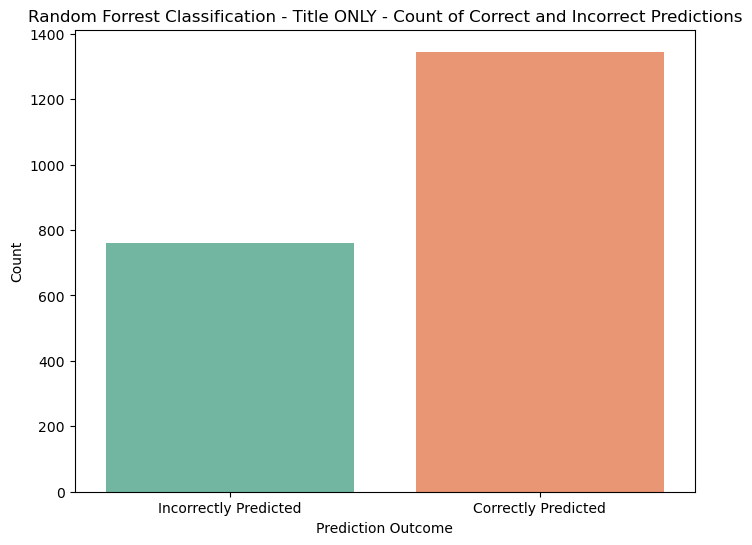

Accuracy: 63.90%


In [37]:
import seaborn as sns
# Create a DataFrame with actual and predicted labels
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create a confusion matrix
conf_matrix = confusion_matrix(results_df['Actual'], results_df['Predicted'])

# Map the actual and predicted labels to "Correctly Predicted" and "Incorrectly Predicted"
results_df['Outcome'] = results_df.apply(lambda row: 'Correctly Predicted' if row['Actual'] == row['Predicted'] else 'Incorrectly Predicted', axis=1)

# Plot the count of correct and incorrect predictions
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=results_df, palette='Set2')

plt.title('Random Forrest Classification - Title ONLY - Count of Correct and Incorrect Predictions')
plt.xlabel('Prediction Outcome')
plt.ylabel('Count')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')